# INTEGRATION OF MULTIPLE DATASETS

In [1]:
import pandas as pd
import numpy as np

# Sales Data
sales_data = {
    'date': pd.date_range(start='2024-01-01', periods=100, freq='D'),
    'sales': np.random.randint(100, 500, size=100)  # Random sales data
}
sales_df = pd.DataFrame(sales_data)
sales_df.set_index('date', inplace=True)

In [3]:
# Logistics Data
logistics_data = {
    'date': pd.date_range(start='2024-01-01', periods=100, freq='D'),
    'delivery_time': np.random.randint(1, 5, size=100),  # Days to deliver
    'delivery_cost': np.random.uniform(10, 50, size=100)  # Cost of delivery
}
logistics_df = pd.DataFrame(logistics_data)
logistics_df.set_index('date', inplace=True)

In [4]:
# Inventory Data
inventory_data = {
    'date': pd.date_range(start='2024-01-01', periods=100, freq='D'),
    'inventory_level': np.random.randint(500, 1000, size=100)  # Inventory stock
}
inventory_df = pd.DataFrame(inventory_data)
inventory_df.set_index('date', inplace=True)

In [5]:
# Add correlations
sales_df['inventory_level'] = inventory_df['inventory_level'] - sales_df['sales'] * 0.5
logistics_df['sales'] = sales_df['sales'] - logistics_df['delivery_time'] * 10

## GRU MODEL

Epoch 1/100


C:\Users\Chaithra.k\anaconda\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


95/95 - 2s - 19ms/step - loss: 0.1270
Epoch 2/100
95/95 - 0s - 4ms/step - loss: 0.1029
Epoch 3/100
95/95 - 0s - 3ms/step - loss: 0.1015
Epoch 4/100
95/95 - 0s - 3ms/step - loss: 0.0969
Epoch 5/100
95/95 - 0s - 4ms/step - loss: 0.1029
Epoch 6/100
95/95 - 0s - 4ms/step - loss: 0.1002
Epoch 7/100
95/95 - 0s - 3ms/step - loss: 0.0968
Epoch 8/100
95/95 - 0s - 3ms/step - loss: 0.0949
Epoch 9/100
95/95 - 0s - 4ms/step - loss: 0.0966
Epoch 10/100
95/95 - 0s - 4ms/step - loss: 0.0955
Epoch 11/100
95/95 - 0s - 3ms/step - loss: 0.0923
Epoch 12/100
95/95 - 0s - 4ms/step - loss: 0.0929
Epoch 13/100
95/95 - 0s - 4ms/step - loss: 0.0931
Epoch 14/100
95/95 - 0s - 4ms/step - loss: 0.0935
Epoch 15/100
95/95 - 0s - 4ms/step - loss: 0.0932
Epoch 16/100
95/95 - 0s - 4ms/step - loss: 0.0927
Epoch 17/100
95/95 - 0s - 4ms/step - loss: 0.0890
Epoch 18/100
95/95 - 0s - 4ms/step - loss: 0.0927
Epoch 19/100
95/95 - 0s - 4ms/step - loss: 0.0893
Epoch 20/100
95/95 - 0s - 4ms/step - loss: 0.0898
Epoch 21/100
95/95 -

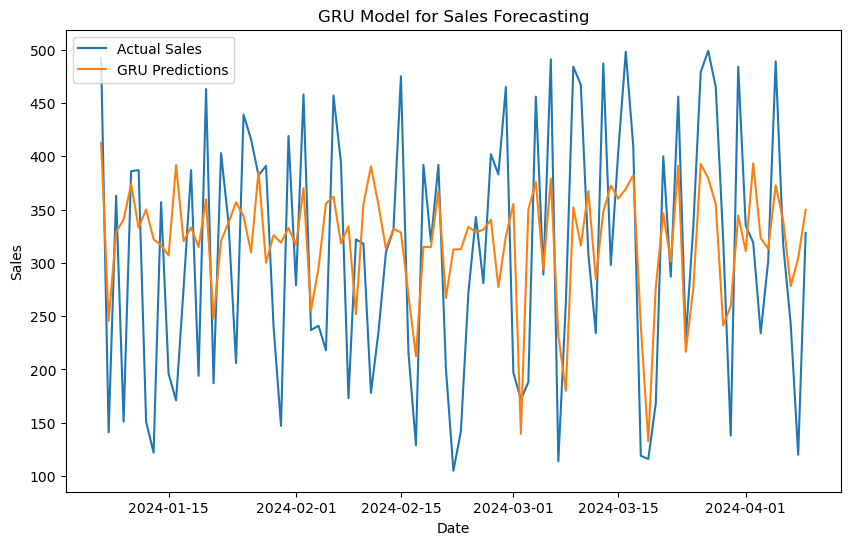

In [8]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
import matplotlib.pyplot as plt

# Prepare data for GRU
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_sales = scaler.fit_transform(sales_df[['sales']].values)

look_back = 5
X, Y = [], []
for i in range(len(scaled_sales) - look_back):
    X.append(scaled_sales[i:(i + look_back), 0])
    Y.append(scaled_sales[i + look_back, 0])
X, Y = np.array(X), np.array(Y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Build GRU model
model = Sequential()
model.add(GRU(50, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X, Y, epochs=100, batch_size=1, verbose=2)

# Predictions
train_predict = model.predict(X)
train_predict = scaler.inverse_transform(train_predict)
Y = scaler.inverse_transform(Y.reshape(-1, 1))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(sales_df.index[look_back:], Y, label='Actual Sales')
plt.plot(sales_df.index[look_back:], train_predict, label='GRU Predictions')
plt.title('GRU Model for Sales Forecasting')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

## PROPHET MODEL 

08:42:32 - cmdstanpy - INFO - Chain [1] start processing
08:42:32 - cmdstanpy - INFO - Chain [1] done processing


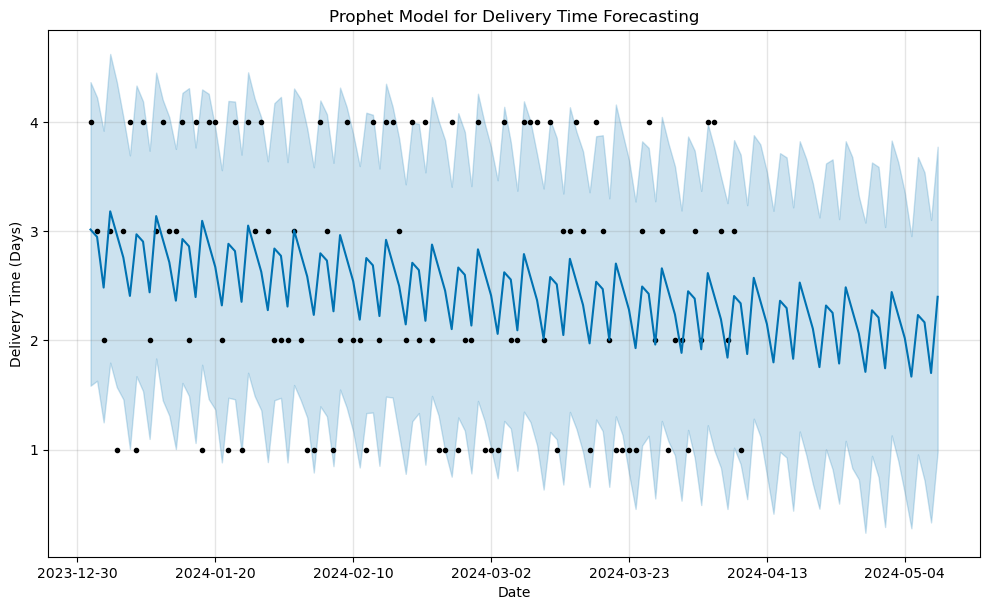

In [9]:
from prophet import Prophet

# Prepare data for Prophet
prophet_df = logistics_df.reset_index()[['date', 'delivery_time']]
prophet_df.columns = ['ds', 'y']

# Fit Prophet model
model = Prophet()
model.fit(prophet_df)

# Forecast
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Plot
fig = model.plot(forecast)
plt.title('Prophet Model for Delivery Time Forecasting')
plt.xlabel('Date')
plt.ylabel('Delivery Time (Days)')
plt.show()

## XGBOOST MODEL

Mean Squared Error: 40545.688734212985


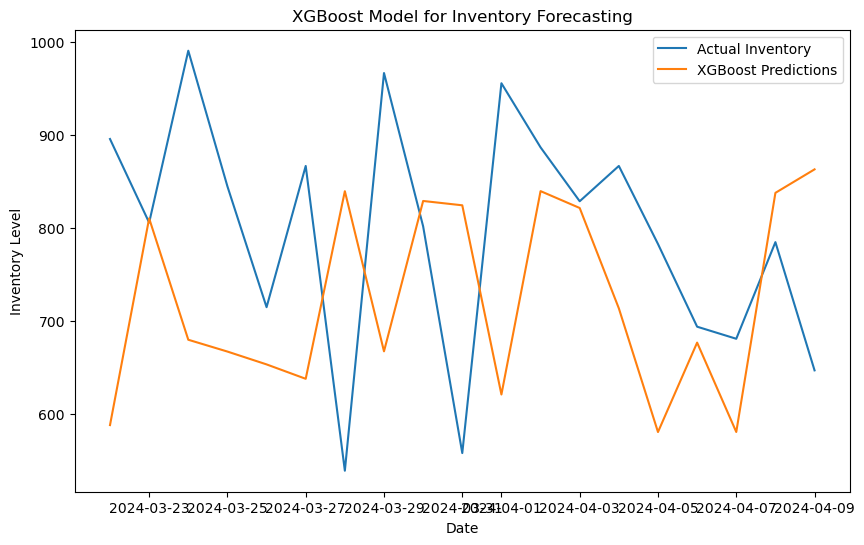

In [35]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Ensure lag features are created correctly
inventory_df['lag1'] = inventory_df['inventory_level'].shift(1)
inventory_df['lag2'] = inventory_df['inventory_level'].shift(2)
inventory_df.dropna(inplace=True)

# Prepare data for XGBoost
X = inventory_df[['lag1', 'lag2']]
y = inventory_df['inventory_level']

# Split data into train and test
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build XGBoost model
model = XGBRegressor(n_estimators=100, learning_rate=0.1)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Align XGBoost predictions with GRU and Prophet
xgboost_predictions = np.full(len(gru_predictions), np.nan)  # Create an array of NaNs with the same length as GRU
xgboost_predictions[-len(y_pred):] = y_pred  # Fill the last part with XGBoost predictions
# Evaluate
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Plot
plt.figure(figsize=(10, 6))
plt.plot(inventory_df.index[train_size:], y_test, label='Actual Inventory')
plt.plot(inventory_df.index[train_size:], y_pred, label='XGBoost Predictions')
plt.title('XGBoost Model for Inventory Forecasting')
plt.xlabel('Date')
plt.ylabel('Inventory Level')
plt.legend()
plt.show()

In [36]:
import matplotlib.animation as animation

# Function to update the graph in real-time
def animate(i):
    plt.cla()
    plt.plot(sales_df.index[:i], sales_df['sales'][:i], label='Sales')
    plt.plot(logistics_df.index[:i], logistics_df['delivery_time'][:i], label='Delivery Time')
    plt.plot(inventory_df.index[:i], inventory_df['inventory_level'][:i], label='Inventory Level')
    plt.title('Real-Time Supply Chain Monitoring')
    plt.xlabel('Date')
    plt.ylabel('Metrics')
    plt.legend()

# Create real-time animation
fig = plt.figure(figsize=(10, 6))
ani = animation.FuncAnimation(fig, animate, frames=len(sales_df), interval=200)
plt.show()

C:\Users\Chaithra.k\anaconda\lib\site-packages\matplotlib\animation.py:880: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


<Figure size 1000x600 with 0 Axes>

## INTEGRATION OF ALL THE MODELS OUTPUTS 

In [37]:
print(f"GRU Predictions Length: {len(gru_predictions)}")
print(f"Prophet Predictions Length: {len(prophet_predictions)}")
print(f"XGBoost Predictions Length: {len(xgboost_predictions)}")

GRU Predictions Length: 95
Prophet Predictions Length: 95
XGBoost Predictions Length: 95


In [38]:
gru_predictions = train_predict.flatten()  # Ensure it's a 1D array
gru_dates = sales_df.index[look_back:look_back + len(gru_predictions)]  # Align dates

In [39]:
prophet_predictions = forecast['yhat'].values[:len(gru_predictions)]  # Trim to match GRU length

In [40]:
xgboost_predictions = y_pred[:len(gru_predictions)]  # Trim to match GRU length

In [43]:
import pandas as pd

# Assuming these variables are defined earlier in your code
# gru_dates, gru_predictions, prophet_predictions, xgboost_predictions

# Step 1: Print lengths to diagnose the issue
print("Length of gru_dates:", len(gru_dates))
print("Length of gru_predictions:", len(gru_predictions))
print("Length of prophet_predictions:", len(prophet_predictions))
print("Length of xgboost_predictions:", len(xgboost_predictions))

# Step 2: Ensure all arrays match the length of gru_dates
min_length = min(len(gru_dates), len(gru_predictions), len(prophet_predictions), len(xgboost_predictions))

# Trim arrays to the shortest length (or handle missing data differently if needed)
gru_dates_trimmed = gru_dates[:min_length]
gru_predictions_trimmed = gru_predictions[:min_length]
prophet_predictions_trimmed = prophet_predictions[:min_length]
xgboost_predictions_trimmed = xgboost_predictions[:min_length]

# Step 3: Create the DataFrame with trimmed arrays
combined_df = pd.DataFrame({
    'date': gru_dates_trimmed,
    'gru_sales': gru_predictions_trimmed,
    'prophet_delivery': prophet_predictions_trimmed,
    'xgboost_inventory': xgboost_predictions_trimmed
})

# Step 4: Set the index
combined_df.set_index('date', inplace=True)

# Display the resulting DataFrame
print(combined_df.head())

Length of gru_dates: 95
Length of gru_predictions: 95
Length of prophet_predictions: 95
Length of xgboost_predictions: 19
             gru_sales  prophet_delivery  xgboost_inventory
date                                                       
2024-01-06  412.660767          3.014722         588.103088
2024-01-07  245.577240          2.947910         810.569031
2024-01-08  328.949219          2.483483         679.947754
2024-01-09  340.742767          3.181617         667.231445
2024-01-10  373.756622          2.970097         653.422546


In [44]:
import numpy as np
max_length = len(gru_dates)
gru_predictions_padded = np.pad(gru_predictions, (0, max_length - len(gru_predictions)), mode='constant', constant_values=np.nan)
prophet_predictions_padded = np.pad(prophet_predictions, (0, max_length - len(prophet_predictions)), mode='constant', constant_values=np.nan)
xgboost_predictions_padded = np.pad(xgboost_predictions, (0, max_length - len(xgboost_predictions)), mode='constant', constant_values=np.nan)

## ENSEMBLE MODEL

Length of gru_dates: 95
Length of gru_predictions: 95
Length of prophet_predictions: 95
Length of xgboost_predictions: 19


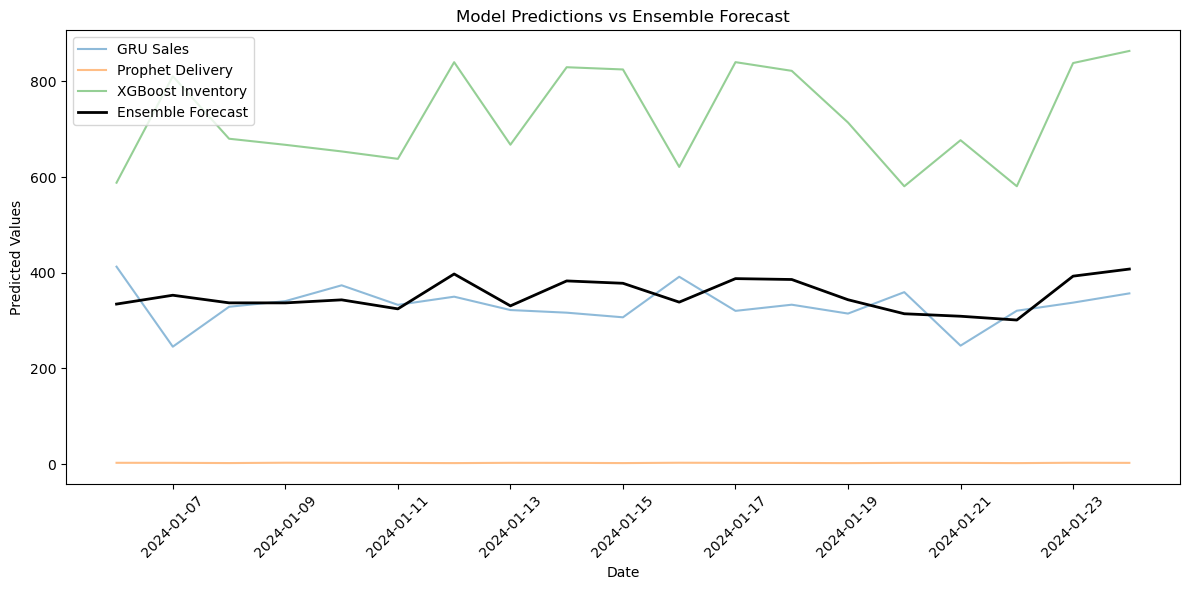

             gru_sales  prophet_delivery  xgboost_inventory  ensemble_forecast
date                                                                          
2024-01-06  412.660767          3.014722         588.103088         334.592859
2024-01-07  245.577240          2.947910         810.569031         353.031393
2024-01-08  328.949219          2.483483         679.947754         337.126819
2024-01-09  340.742767          3.181617         667.231445         337.051943
2024-01-10  373.756622          2.970097         653.422546         343.383089


In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Assuming these are your variables
# gru_dates, gru_predictions, prophet_predictions, xgboost_predictions

# Step 1: Diagnose the issue by checking lengths
print("Length of gru_dates:", len(gru_dates))
print("Length of gru_predictions:", len(gru_predictions))
print("Length of prophet_predictions:", len(prophet_predictions))
print("Length of xgboost_predictions:", len(xgboost_predictions))

# Step 2: Align arrays to the shortest length (or customize based on your needs)
min_length = min(len(gru_dates), len(gru_predictions), len(prophet_predictions), len(xgboost_predictions))

gru_dates_trimmed = gru_dates[:min_length]
gru_predictions_trimmed = gru_predictions[:min_length]
prophet_predictions_trimmed = prophet_predictions[:min_length]
xgboost_predictions_trimmed = xgboost_predictions[:min_length]

# Step 3: Create the combined DataFrame with aligned arrays
combined_df = pd.DataFrame({
    'date': gru_dates_trimmed,
    'gru_sales': gru_predictions_trimmed,
    'prophet_delivery': prophet_predictions_trimmed,
    'xgboost_inventory': xgboost_predictions_trimmed
})
combined_df.set_index('date', inplace=True)

# Step 4: Ensemble - Simple Averaging
combined_df['ensemble_forecast'] = combined_df[['gru_sales', 'prophet_delivery', 'xgboost_inventory']].mean(axis=1)

# Optional: If you have actual values, uncomment and add them
# actual_values = [...]  # Replace with your actual data
# combined_df['actual'] = actual_values[:len(combined_df)]

# Step 5: Evaluate Accuracy (if actual values are available)
if 'actual' in combined_df.columns:
    mae_ensemble = mean_absolute_error(combined_df['actual'], combined_df['ensemble_forecast'])
    mae_gru = mean_absolute_error(combined_df['actual'], combined_df['gru_sales'])
    mae_prophet = mean_absolute_error(combined_df['actual'], combined_df['prophet_delivery'])
    mae_xgboost = mean_absolute_error(combined_df['actual'], combined_df['xgboost_inventory'])
    print(f"MAE Ensemble: {mae_ensemble:.2f}")
    print(f"MAE GRU: {mae_gru:.2f}")
    print(f"MAE Prophet: {mae_prophet:.2f}")
    print(f"MAE XGBoost: {mae_xgboost:.2f}")

# Step 6: Plot the predictions
plt.figure(figsize=(12, 6))
plt.plot(combined_df.index, combined_df['gru_sales'], label='GRU Sales', alpha=0.5)
plt.plot(combined_df.index, combined_df['prophet_delivery'], label='Prophet Delivery', alpha=0.5)
plt.plot(combined_df.index, combined_df['xgboost_inventory'], label='XGBoost Inventory', alpha=0.5)
plt.plot(combined_df.index, combined_df['ensemble_forecast'], label='Ensemble Forecast', linewidth=2, color='black')
if 'actual' in combined_df.columns:
    plt.plot(combined_df.index, combined_df['actual'], label='Actual', linestyle='--', color='red')
plt.xlabel('Date')
plt.ylabel('Predicted Values')
plt.title('Model Predictions vs Ensemble Forecast')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Display the first few rows of the combined DataFrame
print(combined_df.head())

In [47]:
max_length = len(gru_dates)  # Use gru_dates as the reference length
gru_predictions_padded = np.pad(gru_predictions, (0, max_length - len(gru_predictions)), mode='constant', constant_values=np.nan)
prophet_predictions_padded = np.pad(prophet_predictions, (0, max_length - len(prophet_predictions)), mode='constant', constant_values=np.nan)
xgboost_predictions_padded = np.pad(xgboost_predictions, (0, max_length - len(xgboost_predictions)), mode='constant', constant_values=np.nan)

combined_df = pd.DataFrame({
    'date': gru_dates,
    'gru_sales': gru_predictions_padded,
    'prophet_delivery': prophet_predictions_padded,
    'xgboost_inventory': xgboost_predictions_padded
})